In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv
import graphviz

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
pt = PrettyTable()
pt.field_names = ["Model", "Optimal Parameters", "Scoring Metric", "Accuracy", "TPR", "TNR", "FPR", "FNR"]

In [3]:
def split_data(train, train_vectors, test, test_vectors, dense_matrix=False):
    
    y_train = train['Score']
    X_train = train.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)

    print(X_train.shape, train_vectors.shape)
    if dense_matrix:
        X_train = np.hstack((X_train, train_vectors))
    else:
        X_train = sparse.hstack((X_train, train_vectors))
    
    print('X_Train: {0}'.format(X_train.shape))
    print('y_Train: {0}'.format(y_train.shape))
    
    y_test = test['Score']
    X_test = test.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)

    if dense_matrix:
        X_test = np.hstack((X_test, test_vectors))
    else:
        X_test = sparse.hstack((X_test, test_vectors))
    
    print('X_Test: {0}'.format(X_test.shape))
    print('y_Test: {0}'.format(y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [4]:
def plot_scores(optimal_model, param):
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_train_score']), 'g-', \
                     label='Training Scores')
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_test_score']), 'r-', \
                      label='Test Scores')
    _, = plt.plot(optimal_model.best_params_[param], optimal_model.best_score_, 'bo', \
            label=f"Optimal Value ({param}={optimal_model.best_params_[param]}, Score={round(optimal_model.best_score_,2)})")

    plt.xlabel(param)
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

In [5]:
def run_ensemble(train, train_vectors, test, test_vectors, kernel='linear', \
            metric='precision_macro', dense_matrix=True, ensemble='bagging'):
    '''
    Perform Ensemble Classification modelling (Bagging - Random Forest & Boosting - XGBoost) on the I/P Train and Test data.
    1. Remove not required Columns and concatenate data with the text vectors.
    2. Perform Cross Validation and find Optimal parameters - 'max_depth' & 'n_estimators'.
    3. Use the Optimal parameters based model on the Training data and evaluate the Test data.
    4. Evaluate Performance of Model based on TPR, TNR, FPR, FNR.
    '''
    # Drop not required Columns and concatenate data with text vectors
    X_train, y_train, X_test, y_test = split_data(train, train_vectors, test, \
                                                  test_vectors, dense_matrix=dense_matrix)

    del train, train_vectors, test, test_vectors
    
    # Custom Scorer to evaluate the best parameters for highest TNR
    def tnr(y_true, y_pred):
        conf_matrix = confusion_matrix(y_true, y_pred)
        TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
        TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
        FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
        FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
        return TNR        
        
    scoring = {'score': make_scorer(tnr)}

    print('Starting Model build...')
    if ensemble == 'bagging':
        parameters = {'max_depth': [6, 9, 11, 13, 15],
                      'n_estimators': [19, 22, 27, 29, 39]}
        model = RandomForestClassifier(random_state=42, oob_score=True, class_weight='balanced')
    else:
        parameters = {'max_depth': [6, 9, 11, 13, 15],
                      'n_estimators': [50, 75, 100, 150, 200]}
        model = XGBClassifier(random_state=42, colsample_bytree=0.7, \
                              learning_rate=0.01, scale_pos_weight=0.6, \
                             reg_alpha=10, reg_lambda=15)
    
    model_optimal = GridSearchCV(model, param_grid=parameters, \
                                       cv=3, scoring=scoring, verbose=1, refit='score')
    model_optimal.fit(X_train, y_train)
    print('Model building complete...')
    
    # Plot Train vs Test Scores and the Optimal Parameter
    plot_scores(model_optimal, 'max_depth')
    plot_scores(model_optimal, 'n_estimators')

    # Confusion Matrix for Train Data
    pred = []
    for i in range(0, X_train.shape[0], 2000):
        if dense_matrix:
            test_batch = X_train[i:i+2000]
        else:
            test_batch = X_train.todok()[i:i+2000]
        pred.extend(model_optimal.predict(test_batch))
    conf_matrix = confusion_matrix(y_train, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Train Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    
    del X_train, y_train
    
    # Confusion Matrix for Test Data
    pred = []
    for i in range(0, X_test.shape[0], 2000):
        if dense_matrix:
            test_batch = X_test[i:i+2000]
        else:
            test_batch = X_test.todok()[i:i+2000]
        pred.extend(model_optimal.predict(test_batch))

    ps = accuracy_score(y_test, pred) * 100
    print(f'\nAccuracy of the Optimal Ensemble Classifier with parameters-{model_optimal.best_params_} is {ps} %')
    
    conf_matrix = confusion_matrix(y_test, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Test Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    print('\nClassification Report :-\n')
    print(classification_report(y_test, pred))
    
    # Plot Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data
    cols = np.unique(model_optimal.cv_results_['param_n_estimators'].data)
    indx = np.unique(model_optimal.cv_results_['param_max_depth'].data)
    data = model_optimal.cv_results_['mean_test_score'].reshape(indx.shape[0], cols.shape[0])
    hyper_params = pd.DataFrame(data=data, columns=cols, index= indx)
    hyper_params.fillna(value=0.0, inplace=True)
    print("\nHeatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-")
    sns.heatmap(hyper_params, annot=True, fmt='f', cmap='coolwarm')

    return [model_optimal.best_params_, "True Negative Rate", round(ps,2), round(TPR*100,2), round(TNR*100,2), \
            round(FPR*100,2), round(FNR*100,2), model_optimal.cv_results_, model_optimal.best_estimator_]

In [6]:
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')

## BOW Vectorizer based Random Forest

In [7]:
%%time
cv_model = CountVectorizer(max_features=2000, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 2000) (24000, 2000)
Wall time: 3.74 s


(56000, 4) (56000, 2000)
X_Train: (56000, 2004)
y_Train: (56000,)
X_Test: (24000, 2004)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 10.8min finished


Model building complete...


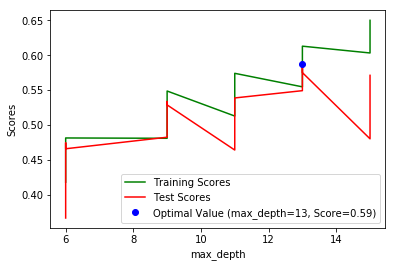

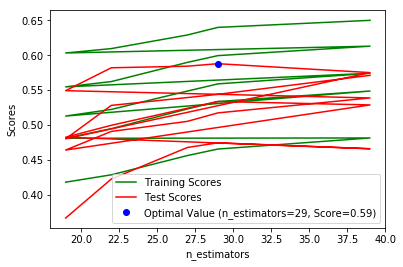


Confusion Matrix for Train Data :-
[[ 6533  1129]
 [ 4771 43567]]

TPR: 97.47404689457669 %
TNR: 57.79370134465675 %
FPR: 42.20629865534325 %
FNR: 2.525953105423304 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 13, 'n_estimators': 29} is 88.9375 %

Confusion Matrix for Test Data :-
[[ 3076  1023]
 [ 1632 18269]]

TPR: 94.69728384822724 %
TNR: 65.3355989804588 %
FPR: 34.66440101954121 %
FNR: 5.3027161517727555 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.65      0.75      0.70      4099
           1       0.95      0.92      0.93     19901

   micro avg       0.89      0.89      0.89     24000
   macro avg       0.80      0.83      0.82     24000
weighted avg       0.90      0.89      0.89     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 11min 5s


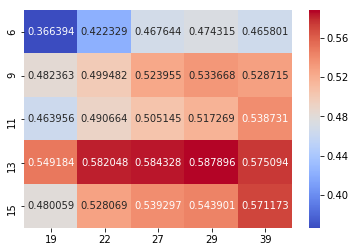

In [8]:
%%time
info = run_ensemble(data_train, bow_counts_train.toarray(), data_test, bow_counts_test.toarray())

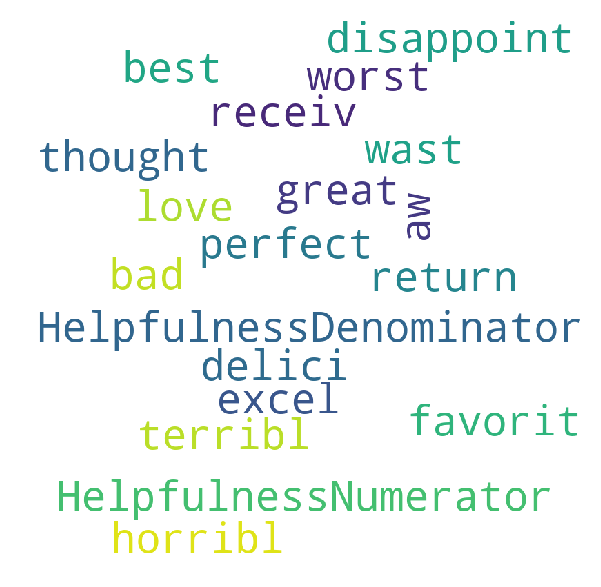

In [9]:
n = 20; coeffs = info[-1].feature_importances_;
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + cv_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names), reverse=True)
top = ' '.join([j for i,j in coefs_with_fns[:n]])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(top) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [10]:
%%time
pt.add_row(['BOW (RF)'] + info[:-2])
print(pt)

+----------+---------------------------------------+--------------------+----------+------+-------+-------+-----+
|  Model   |           Optimal Parameters          |   Scoring Metric   | Accuracy | TPR  |  TNR  |  FPR  | FNR |
+----------+---------------------------------------+--------------------+----------+------+-------+-------+-----+
| BOW (RF) | {'max_depth': 13, 'n_estimators': 29} | True Negative Rate |  88.94   | 94.7 | 65.34 | 34.66 | 5.3 |
+----------+---------------------------------------+--------------------+----------+------+-------+-------+-----+
Wall time: 0 ns


## BOW Vectorizer based XGBoost

In [11]:
%%time
cv_model = CountVectorizer(max_features=200, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 200) (24000, 200)
Wall time: 3.04 s


(56000, 4) (56000, 200)
X_Train: (56000, 204)
y_Train: (56000,)
X_Test: (24000, 204)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 86.5min finished
C:\Users\Jeet\Anaconda3\envs\virtual_env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model building complete...


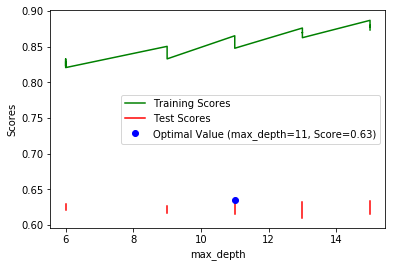

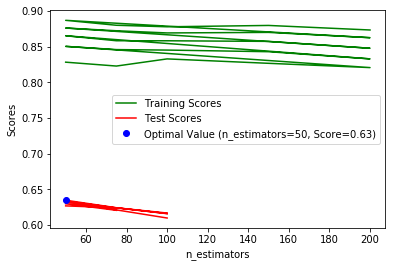


Confusion Matrix for Train Data :-
[[ 3061  4601]
 [  582 47756]]

TPR: 91.21225433084402 %
TNR: 84.02415591545429 %
FPR: 15.975844084545704 %
FNR: 8.787745669155987 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 11, 'n_estimators': 50} is 87.29583333333333 %

Confusion Matrix for Test Data :-
[[ 1331  2768]
 [  281 19620]]

TPR: 87.6362336966232 %
TNR: 82.5682382133995 %
FPR: 17.431761786600497 %
FNR: 12.36376630337681 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.83      0.32      0.47      4099
           1       0.88      0.99      0.93     19901

   micro avg       0.87      0.87      0.87     24000
   macro avg       0.85      0.66      0.70     24000
weighted avg       0.87      0.87      0.85     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 1h 27min 14s


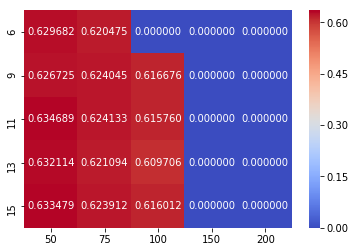

In [12]:
%%time
info = run_ensemble(data_train, bow_counts_train.toarray(), data_test, bow_counts_test.toarray(), ensemble='boosting')

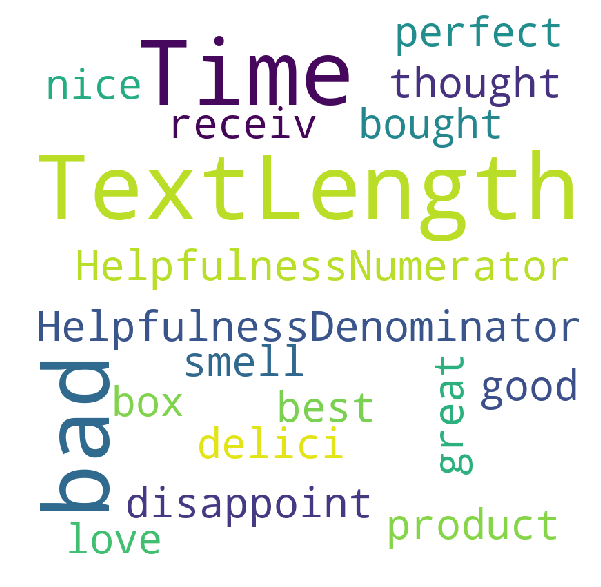

In [13]:
n = 20; coeffs = info[-1].feature_importances_;
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + cv_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names), reverse=True)
top = ' '.join([j for i,j in coefs_with_fns[:n]])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(top) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [14]:
%%time
pt.add_row(['BOW (XGBDT)'] + info[:-2])
print(pt)

+-------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|    Model    |           Optimal Parameters          |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|   BOW (RF)  | {'max_depth': 13, 'n_estimators': 29} | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
| BOW (XGBDT) | {'max_depth': 11, 'n_estimators': 50} | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
+-------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 0 ns


In [15]:
del cv_model, bow_counts_train, bow_counts_test

## TFIDF Vectorizer based Random Forest

In [16]:
%%time
tfidf_model = TfidfVectorizer(max_features=2000, min_df=10)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 2000) (24000, 2000)
Wall time: 2.75 s


(56000, 4) (56000, 2000)
X_Train: (56000, 2004)
y_Train: (56000,)
X_Test: (24000, 2004)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 10.1min finished


Model building complete...


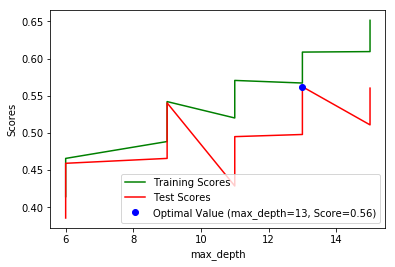

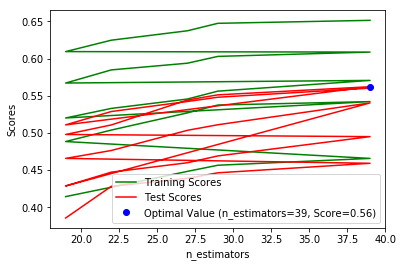


Confusion Matrix for Train Data :-
[[ 6639  1023]
 [ 4890 43448]]

TPR: 97.69962447437656 %
TNR: 57.58521988030185 %
FPR: 42.41478011969815 %
FNR: 2.3003755256234397 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 13, 'n_estimators': 39} is 88.00833333333333 %

Confusion Matrix for Test Data :-
[[ 3142   957]
 [ 1921 17980]]

TPR: 94.94640122511485 %
TNR: 62.05806833892949 %
FPR: 37.94193166107051 %
FNR: 5.053598774885145 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      4099
           1       0.95      0.90      0.93     19901

   micro avg       0.88      0.88      0.88     24000
   macro avg       0.79      0.84      0.81     24000
weighted avg       0.89      0.88      0.88     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 10min 29s


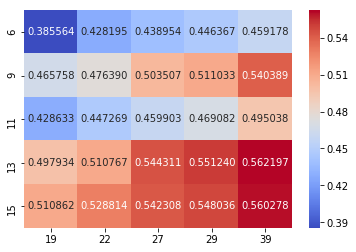

In [17]:
%%time
info = run_ensemble(data_train, tfidf_train.toarray(), data_test, tfidf_test.toarray())

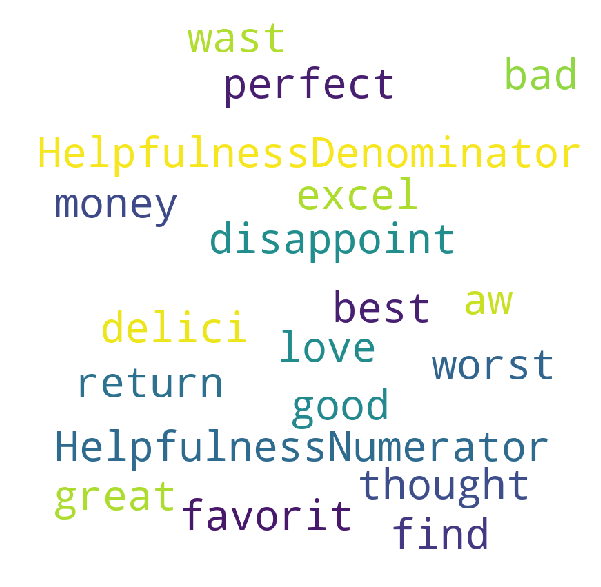

Wall time: 1.87 s


In [18]:
%%time
n = 20; coeffs = info[-1].feature_importances_;
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + tfidf_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names), reverse=True)
top = ' '.join([j for i,j in coefs_with_fns[:n]])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(top) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [19]:
%%time
pt.add_row(['TFIDF (RF)'] + info[:-2])
print(pt)

+-------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|    Model    |           Optimal Parameters          |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|   BOW (RF)  | {'max_depth': 13, 'n_estimators': 29} | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
| BOW (XGBDT) | {'max_depth': 11, 'n_estimators': 50} | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|  TFIDF (RF) | {'max_depth': 13, 'n_estimators': 39} | True Negative Rate |  88.01   | 94.95 | 62.06 | 37.94 |  5.05 |
+-------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 0 ns


## TFIDF Vectorizer based XGBoost

In [20]:
%%time
tfidf_model = TfidfVectorizer(max_features=200, min_df=10)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 200) (24000, 200)
Wall time: 2.81 s


(56000, 4) (56000, 200)
X_Train: (56000, 204)
y_Train: (56000,)
X_Test: (24000, 204)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 90.2min finished
C:\Users\Jeet\Anaconda3\envs\virtual_env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model building complete...


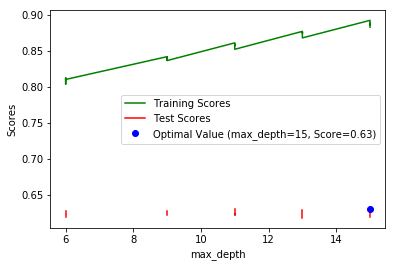

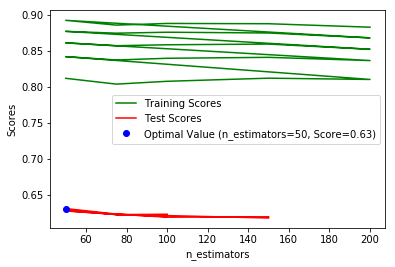


Confusion Matrix for Train Data :-
[[ 3534  4128]
 [  546 47792]]

TPR: 92.04930662557781 %
TNR: 86.61764705882354 %
FPR: 13.382352941176471 %
FNR: 7.950693374422188 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 15, 'n_estimators': 50} is 87.6625 %

Confusion Matrix for Test Data :-
[[ 1431  2668]
 [  293 19608]]

TPR: 88.02298437780571 %
TNR: 83.0046403712297 %
FPR: 16.995359628770302 %
FNR: 11.97701562219429 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.83      0.35      0.49      4099
           1       0.88      0.99      0.93     19901

   micro avg       0.88      0.88      0.88     24000
   macro avg       0.86      0.67      0.71     24000
weighted avg       0.87      0.88      0.85     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 1h 31min 18s


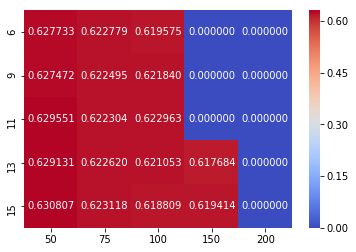

In [21]:
%%time
info = run_ensemble(data_train, tfidf_train.toarray(), data_test, tfidf_test.toarray(), ensemble="boosting")

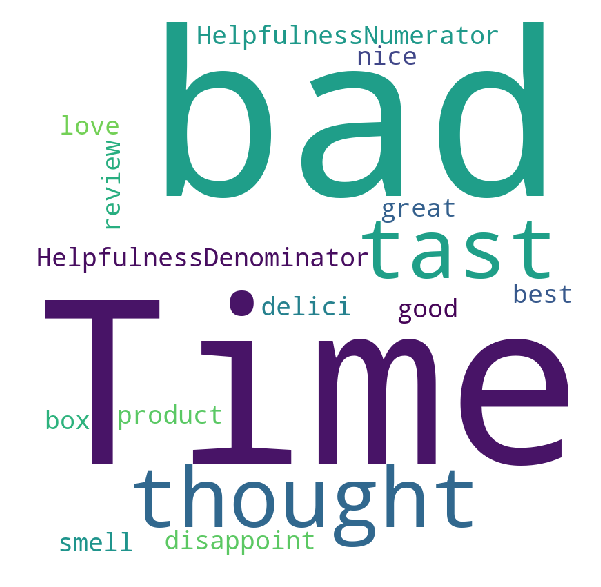

Wall time: 984 ms


In [22]:
%%time
n = 20; coeffs = info[-1].feature_importances_;
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + tfidf_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names), reverse=True)
top = ' '.join([j for i,j in coefs_with_fns[:n]])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(top) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [23]:
%%time
pt.add_row(['TFIDF (XGBDT)'] + info[:-2])
print(pt)

+---------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|     Model     |           Optimal Parameters          |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+---------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|    BOW (RF)   | {'max_depth': 13, 'n_estimators': 29} | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
|  BOW (XGBDT)  | {'max_depth': 11, 'n_estimators': 50} | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|   TFIDF (RF)  | {'max_depth': 13, 'n_estimators': 39} | True Negative Rate |  88.01   | 94.95 | 62.06 | 37.94 |  5.05 |
| TFIDF (XGBDT) | {'max_depth': 15, 'n_estimators': 50} | True Negative Rate |  87.66   | 88.02 |  83.0 |  17.0 | 11.98 |
+---------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 0 ns


In [24]:
del tfidf_model, tfidf_train, tfidf_test

## Avg. W2V Vectorizer based Random Forest

In [25]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/avg_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/avg_w2v_test.csv')

Wall time: 1.53 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  6.4min finished
C:\Users\Jeet\Anaconda3\envs\virtual_env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model building complete...


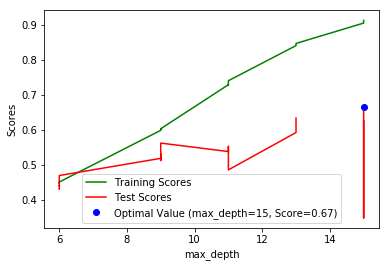

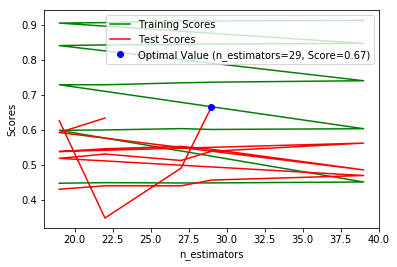


Confusion Matrix for Train Data :-
[[ 7581    81]
 [  913 47425]]

TPR: 99.82949522165622 %
TNR: 89.25123616670591 %
FPR: 10.74876383329409 %
FNR: 0.17050477834378816 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 15, 'n_estimators': 29} is 88.57916666666667 %

Confusion Matrix for Test Data :-
[[ 2175  1924]
 [  817 19084]]

TPR: 90.84158415841584 %
TNR: 72.69385026737967 %
FPR: 27.306149732620323 %
FNR: 9.158415841584159 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.73      0.53      0.61      4099
           1       0.91      0.96      0.93     19901

   micro avg       0.89      0.89      0.89     24000
   macro avg       0.82      0.74      0.77     24000
weighted avg       0.88      0.89      0.88     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 6min 33s


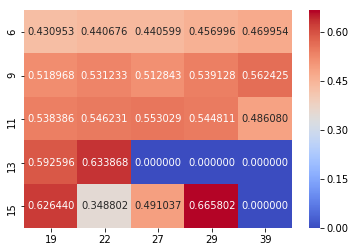

In [26]:
%%time
info = run_ensemble(data_train, sent_vectors_train, data_test, sent_vectors_test)

In [27]:
%%time
pt.add_row(['Avg. W2V (RF)'] + info[:-2])
print(pt)

+---------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|     Model     |           Optimal Parameters          |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+---------------+---------------------------------------+--------------------+----------+-------+-------+-------+-------+
|    BOW (RF)   | {'max_depth': 13, 'n_estimators': 29} | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
|  BOW (XGBDT)  | {'max_depth': 11, 'n_estimators': 50} | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|   TFIDF (RF)  | {'max_depth': 13, 'n_estimators': 39} | True Negative Rate |  88.01   | 94.95 | 62.06 | 37.94 |  5.05 |
| TFIDF (XGBDT) | {'max_depth': 15, 'n_estimators': 50} | True Negative Rate |  87.66   | 88.02 |  83.0 |  17.0 | 11.98 |
| Avg. W2V (RF) | {'max_depth': 15, 'n_estimators': 29} | True Negative Rate |  88.58   | 90.84 | 72.69 | 27.31 |  9.16 |
+---------------+-------

## Avg. W2V Vectorizer based XGBoost

(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 62.2min finished


Model building complete...


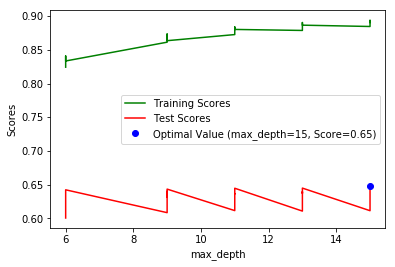

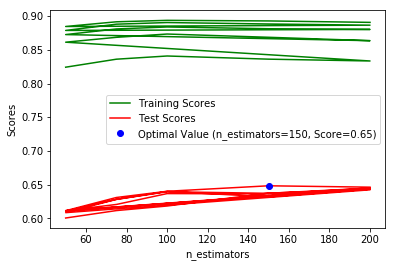


Confusion Matrix for Train Data :-
[[ 4577  3085]
 [  628 47710]]

TPR: 93.92656757554877 %
TNR: 87.9346781940442 %
FPR: 12.065321805955811 %
FNR: 6.073432424451226 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 15, 'n_estimators': 150} is 89.37083333333334 %

Confusion Matrix for Test Data :-
[[ 1954  2145]
 [  406 19495]]

TPR: 90.08780036968577 %
TNR: 82.79661016949153 %
FPR: 17.203389830508474 %
FNR: 9.912199630314234 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.83      0.48      0.61      4099
           1       0.90      0.98      0.94     19901

   micro avg       0.89      0.89      0.89     24000
   macro avg       0.86      0.73      0.77     24000
weighted avg       0.89      0.89      0.88     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 1h 4min 33s


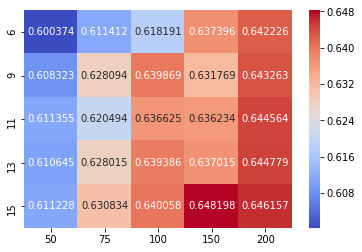

In [28]:
%%time
info = run_ensemble(data_train, sent_vectors_train, data_test, sent_vectors_test, ensemble='boosting')

In [29]:
%%time
pt.add_row(['Avg. W2V (XGBDT)'] + info[:-2])
print(pt)

+------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|      Model       |           Optimal Parameters           |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|     BOW (RF)     | {'max_depth': 13, 'n_estimators': 29}  | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
|   BOW (XGBDT)    | {'max_depth': 11, 'n_estimators': 50}  | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|    TFIDF (RF)    | {'max_depth': 13, 'n_estimators': 39}  | True Negative Rate |  88.01   | 94.95 | 62.06 | 37.94 |  5.05 |
|  TFIDF (XGBDT)   | {'max_depth': 15, 'n_estimators': 50}  | True Negative Rate |  87.66   | 88.02 |  83.0 |  17.0 | 11.98 |
|  Avg. W2V (RF)   | {'max_depth': 15, 'n_estimators': 29}  | True Negative Rate |  88.58   | 90.84 | 72.69 | 27.31 | 

## TFIDF-weighted W2V Vectorizer based Random Forest

In [30]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/tfidf_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/tfidf_w2v_test.csv')

Wall time: 1.71 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  6.4min finished
C:\Users\Jeet\Anaconda3\envs\virtual_env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model building complete...


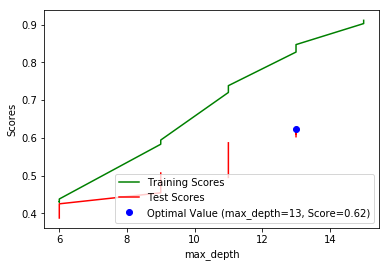

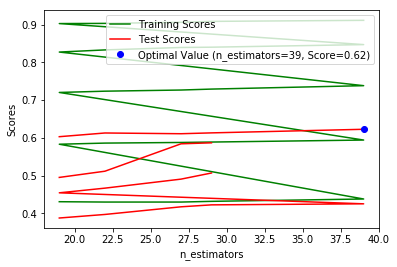


Confusion Matrix for Train Data :-
[[ 7476   186]
 [ 1688 46650]]

TPR: 99.6028695874968 %
TNR: 81.5800960279354 %
FPR: 18.4199039720646 %
FNR: 0.39713041250320263 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 13, 'n_estimators': 39} is 87.55833333333334 %

Confusion Matrix for Test Data :-
[[ 2154  1945]
 [ 1041 18860]]

TPR: 90.65128574861812 %
TNR: 67.41784037558686 %
FPR: 32.582159624413144 %
FNR: 9.348714251381878 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      4099
           1       0.91      0.95      0.93     19901

   micro avg       0.88      0.88      0.88     24000
   macro avg       0.79      0.74      0.76     24000
weighted avg       0.87      0.88      0.87     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 6min 39s


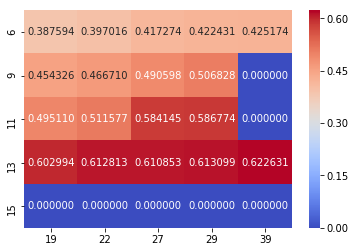

In [38]:
%%time
info = run_ensemble(data_train, sent_vectors_train, data_test, sent_vectors_test)

In [39]:
%%time
pt.add_row(['TFIDF W2V (RF)'] + info[:-2])
print(pt)

+-------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|       Model       |           Optimal Parameters           |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|      BOW (RF)     | {'max_depth': 13, 'n_estimators': 29}  | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
|    BOW (XGBDT)    | {'max_depth': 11, 'n_estimators': 50}  | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|     TFIDF (RF)    | {'max_depth': 13, 'n_estimators': 39}  | True Negative Rate |  88.01   | 94.95 | 62.06 | 37.94 |  5.05 |
|   TFIDF (XGBDT)   | {'max_depth': 15, 'n_estimators': 50}  | True Negative Rate |  87.66   | 88.02 |  83.0 |  17.0 | 11.98 |
|   Avg. W2V (RF)   | {'max_depth': 15, 'n_estimators': 29}  | True Negative Rate |  88.58   | 90.84 | 72.69 | 

## TFIDF-weighted W2V Vectorizer based XGBoost

(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)
Starting Model build...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 62.2min finished


Model building complete...


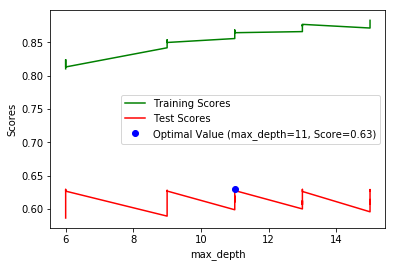

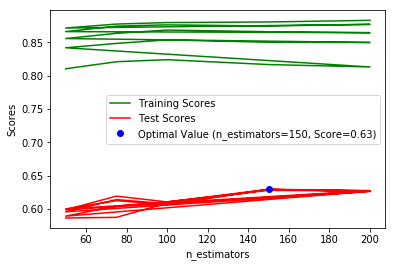


Confusion Matrix for Train Data :-
[[ 3976  3686]
 [  717 47621]]

TPR: 92.81579511567622 %
TNR: 84.72192627317281 %
FPR: 15.278073726827191 %
FNR: 7.184204884323776 %


Accuracy of the Optimal Ensemble Classifier with parameters-{'max_depth': 11, 'n_estimators': 150} is 88.0125 %

Confusion Matrix for Test Data :-
[[ 1593  2506]
 [  371 19530]]

TPR: 88.6277001270648 %
TNR: 81.10997963340122 %
FPR: 18.89002036659878 %
FNR: 11.372299872935198 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.81      0.39      0.53      4099
           1       0.89      0.98      0.93     19901

   micro avg       0.88      0.88      0.88     24000
   macro avg       0.85      0.68      0.73     24000
weighted avg       0.87      0.88      0.86     24000


Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data :-
Wall time: 1h 3min 58s


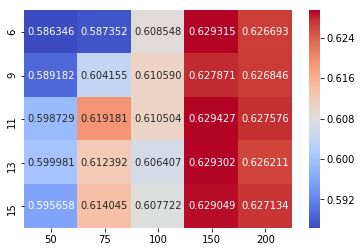

In [33]:
%%time
info = run_ensemble(data_train, sent_vectors_train, data_test, sent_vectors_test, ensemble='boosting')

In [34]:
%%time
pt.add_row(['TFIDF W2V (XGBDT)'] + info[:-2])
print(pt)

+-------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|       Model       |           Optimal Parameters           |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|      BOW (RF)     | {'max_depth': 13, 'n_estimators': 29}  | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
|    BOW (XGBDT)    | {'max_depth': 11, 'n_estimators': 50}  | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|     TFIDF (RF)    | {'max_depth': 13, 'n_estimators': 39}  | True Negative Rate |  88.01   | 94.95 | 62.06 | 37.94 |  5.05 |
|   TFIDF (XGBDT)   | {'max_depth': 15, 'n_estimators': 50}  | True Negative Rate |  87.66   | 88.02 |  83.0 |  17.0 | 11.98 |
|   Avg. W2V (RF)   | {'max_depth': 15, 'n_estimators': 29}  | True Negative Rate |  88.58   | 90.84 | 72.69 | 

In [41]:
print(pt.get_string(sortby='Model'))

+-------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|       Model       |           Optimal Parameters           |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------------+----------------------------------------+--------------------+----------+-------+-------+-------+-------+
|   Avg. W2V (RF)   | {'max_depth': 15, 'n_estimators': 29}  | True Negative Rate |  88.58   | 90.84 | 72.69 | 27.31 |  9.16 |
|  Avg. W2V (XGBDT) | {'max_depth': 15, 'n_estimators': 150} | True Negative Rate |  89.37   | 90.09 |  82.8 |  17.2 |  9.91 |
|      BOW (RF)     | {'max_depth': 13, 'n_estimators': 29}  | True Negative Rate |  88.94   |  94.7 | 65.34 | 34.66 |  5.3  |
|    BOW (XGBDT)    | {'max_depth': 11, 'n_estimators': 50}  | True Negative Rate |   87.3   | 87.64 | 82.57 | 17.43 | 12.36 |
|     TFIDF (RF)    | {'max_depth': 13, 'n_estimators': 39}  | True Negative Rate |  88.01   | 94.95 | 62.06 | 

# Conclusions :-
-  The Dataset being highly imbalanced (8:1) the Scoring metric has been selected based on the Model performance of - high TPR & TNR and low FPR & FNR.
-  Based on the above performance criteria, a Custom Scorer has been used to evaluate the best Model w.r.t. True Negative Rate (TNR).
- While working with Random Forest algo, it was seen that changing the criteria - "oob_score=True, class_weight='balanced'" improved Model performance significantly.
- While working with XGBoost, it was observed that the Model was overfitting a lot (High Training Performance with Low Test Performance). This was handled by increasing L1 & L2 Regularization parameters.
-  From the Performances obtained on the four Vectorizer models, it has been observed that TFIDF Vectorizer based XGBoost Model is giving the best True Negative Rate (TNR) while Avg. W2V based XGBoost Model is giving overall good performance.